
# GPT-2 Decoder Model for Sentiment Classification (extra task)

This notebook implements a sentiment classification pipeline using a decoder-based transformer model (GPT-2).
We classify financial tweets into three sentiment categories: **bearish (0), neutral (1), bullish (2)**.
The notebook includes steps for data loading, preprocessing, tokenization, model configuration, training, and evaluation.

---


In [18]:
# !pip install transformers datasets scikit-learn pandas torch
# !pip install accelerate

In [19]:
# !pip uninstall -y transformers
# !pip install transformers


## Import Required Libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments,TrainerCallback, EarlyStoppingCallback

In [46]:
# Load train and test data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [47]:
print(train_df.head())
print(test_df.head())

                                                text  label
0  $BYND - JPMorgan reels in expectations on Beyo...      0
1  $CCL $RCL - Nomura points to bookings weakness...      0
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3  $ESS: BTIG Research cuts to Neutral https://t....      0
4  $FNKO - Funko slides after Piper Jaffray PT cu...      0
   id                                               text
0   0  ETF assets to surge tenfold in 10 years to $50...
1   1  Here’s What Hedge Funds Think Evolution Petrol...
2   2  $PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3   3  China is in the process of waiving retaliatory...
4   4  Highlight: “When growth is scarce, investors s...


We perform basic data preprocessing that was applied in the preprocessing file as well, the only difference is that we do not remove non-alphanumeric characters becuase we want to preserve emojis, punctuation, and special characters - thats how GPT2 was trained.

In [48]:
def clean_text_gpt2(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [49]:
# Applying the preprocessing
train_df['text'] = train_df['text'].apply(clean_text_gpt2)
test_df['text'] = test_df['text'].apply(clean_text_gpt2)

## Load Tokenizer

In [50]:
# Prepare GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT2 has no pad token so we have to implement as well to ensure that every

In [51]:
# Spliting train into train and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'].tolist(),
    train_df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=train_df['label'].tolist()
)

In [52]:
# Tokenize the data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True, max_length=128)

In [53]:
# Dataset class
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [54]:
# Custom callback to store losses and metrics
class LossAndMetricsLogger(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.eval_accuracies = []
        self.eval_f1s = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])
            if 'eval_accuracy' in logs:
                self.eval_accuracies.append(logs['eval_accuracy'])
            if 'eval_f1' in logs:
                self.eval_f1s.append(logs['eval_f1'])

logger = LossAndMetricsLogger()

In [55]:
train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings)

## Load GPT-2 Model with Classification Head

In [56]:
# Load GPT2 decoder model for classification (we have three labels 0,1,2)
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=3)
model.config.pad_token_id = model.config.eos_token_id

model.config.hidden_dropout_prob = 0.3
model.config.attn_pdrop = 0.3
model.config.embd_pdrop = 0.3

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define Evaluation Metrics

In [57]:
# Evaluation Metrics - we are using macrof1 score because our labels are inbalanced
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## Train the model
<br> Model is trained to look for the best macroF1 score.

In [33]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    learning_rate=5e-5,
    weight_decay=0.05,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1", # we are considering macro f1 score for evaluation of the best model
    save_total_limit=1,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[logger, EarlyStoppingCallback(early_stopping_patience=2)]
)

In [34]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: karpieniajulia (karpieniajulia-nova-ims-su) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.347700,0.480566,0.836040,0.778741,0.803213,0.761445
2,0.339600,0.471982,0.855422,0.809872,0.819728,0.801838
3,0.358400,0.859906,0.861184,0.810438,0.838415,0.788139
4,0.250100,0.888943,0.849660,0.811254,0.799590,0.825211
5,0.174700,1.145403,0.860136,0.818516,0.820495,0.816693
6,0.062400,1.439283,0.854374,0.810353,0.822937,0.800320
7,0.000300,1.526135,0.850183,0.809497,0.801809,0.819824


TrainOutput(global_step=6685, training_loss=0.23433281272802325, metrics={'train_runtime': 1774.319, 'train_samples_per_second': 43.025, 'train_steps_per_second': 5.382, 'total_flos': 2781751537281024.0, 'train_loss': 0.23433281272802325, 'epoch': 7.0})

## Plot the train and validation loss

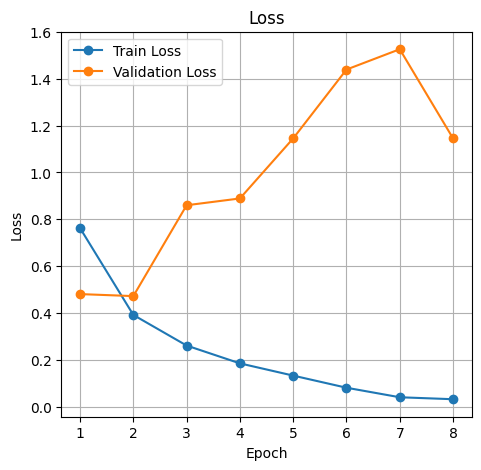

In [38]:
# Calculate train losses per epoch
train_steps_per_epoch = len(logger.train_losses) // len(logger.eval_losses)
train_losses_epoch = [
    np.mean(logger.train_losses[i*train_steps_per_epoch : (i+1)*train_steps_per_epoch])
    for i in range(len(logger.eval_losses))
]
epochs = range(1, len(logger.eval_losses) + 1)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses_epoch, label="Train Loss", marker='o')
plt.plot(epochs, logger.eval_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.grid(True)


We got the best macroF1 score for the 5th epoch, but in that epoch difference between training and validation loss is quite significant which means that model fits the training data much better than it generalizes to new (validation) data. Mostly due to many epochs.

<br> Thus, as the best model we choose epoch 2 which generalize much better and it is a good trade-off between loss and other metrics.

## Running the best model

In [58]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results_epoch2",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    learning_rate=5e-5,
    weight_decay=0.05,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2
)


# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[logger, EarlyStoppingCallback(early_stopping_patience=2)]
)

In [59]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.321600,0.475040,0.834468,0.780105,0.790584,0.780787
2,0.198200,0.400639,0.860660,0.817901,0.815951,0.820209


TrainOutput(global_step=1910, training_loss=0.5665539796439765, metrics={'train_runtime': 474.335, 'train_samples_per_second': 32.188, 'train_steps_per_second': 4.027, 'total_flos': 794786153508864.0, 'train_loss': 0.5665539796439765, 'epoch': 2.0})

## Evaluation of the best model (second epoch)


Classification Report on Validation Set:

              precision    recall  f1-score   support

 Bearish (0)     0.7424    0.7604    0.7513       288
 Bullish (1)     0.8138    0.7948    0.8042       385
 Neutral (2)     0.9023    0.9037    0.9030      1236

    accuracy                         0.8601      1909
   macro avg     0.8195    0.8196    0.8195      1909
weighted avg     0.8603    0.8601    0.8602      1909



<Figure size 600x600 with 0 Axes>

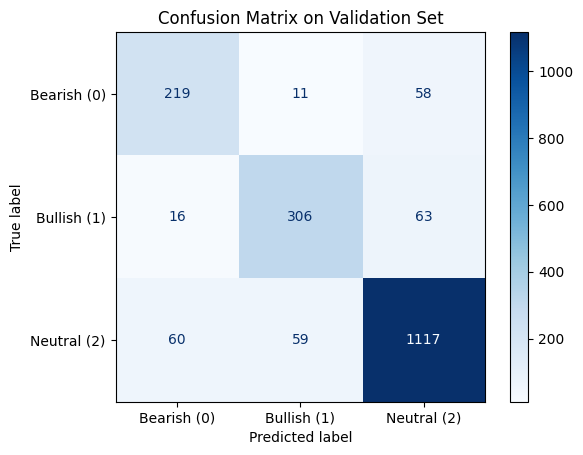

In [43]:
# Predict on validation set
predictions_val = trainer.predict(val_dataset)

# Extract true labels and predicted labels
y_true = predictions_val.label_ids
y_pred = predictions_val.predictions.argmax(axis=1)

# Classification report
target_names = ["Bearish (0)", "Bullish (1)", "Neutral (2)"]
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)

print("\nClassification Report on Validation Set:\n")
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix on Validation Set")
plt.show()


In [44]:
# Predict on test set
predictions = trainer.predict(test_dataset)
preds_test = np.argmax(predictions.predictions, axis=1)

In [ ]:
# # File with test label for submission
# test_df['label'] = preds
# test_df[['id','label']].to_csv("pred_decoder.csv", index=False)

# print("Prediction file saved as pred_decoder.csv")